### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# HiFi GAN

*Author: NVIDIA*

**The HiFi GAN model for generating waveforms from mel spectrograms**

<img src="https://pytorch.org/assets/images/hifigan_model.png" alt="alt" width="50%"/>



### Model Description
This notebook demonstrates a PyTorch implementation of the HiFi-GAN model described in the paper: [HiFi-GAN: Generative Adversarial Networks for Efficient and High Fidelity Speech Synthesis](https://arxiv.org/abs/2010.05646).
The HiFi-GAN model implements a spectrogram inversion model that allows to synthesize speech waveforms from mel-spectrograms. It follows the generative adversarial network (GAN) paradigm, and is composed of a generator and a discriminator. After training, the generator is used for synthesis, and the discriminator is discarded.

Our implementation is based on the one [published by the authors of the paper](https://github.com/jik876/hifi-gan). We modify the original hyperparameters and provide an alternative training recipe, which enables training on larger batches and faster convergence. HiFi-GAN is trained on a publicly available [LJ Speech dataset](https://keithito.com/LJ-Speech-Dataset/). The <a href="audio/">samples</a> demonstrate speech synthesized with our publicly available FastPitch and HiFi-GAN checkpoints.

#### Model architecture

![HiFiGAN Architecture](https://raw.githubusercontent.com/NVIDIA/DeepLearningExamples/master/PyTorch/SpeechSynthesis/HiFiGAN/img/hifigan_model.png)

### Example
In the example below:

- pretrained FastPitch and HiFiGAN models are loaded from torch.hub
- given tensor representation of an input text ("Say this smoothly to prove you are not a robot."), FastPitch generates mel spectrogram
- HiFiGAN generates sound given the mel spectrogram
- the output sound is saved in an 'audio.wav' file

To run the example you need some extra python packages installed. These are needed for preprocessing of text and audio, as well as for display and input/output handling. Finally, for better performance of FastPitch model, we download the CMU pronounciation dictionary.

In [1]:
%%bash
pip install numpy scipy librosa unidecode inflect librosa matplotlib #==3.6.3
sudo  apt-get update 
sudo apt-get install -y libsndfile1 wget
wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/heteronyms-052722 -qO heteronyms
wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 -qO cmudict-0.7b

sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required
sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required


In [2]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


Download and setup FastPitch generator model.

In [3]:
fastpitch, generator_train_setup = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_fastpitch')

Using cache found in /home/asif/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Download and setup vocoder and denoiser models.

In [4]:
hifigan, vocoder_train_setup, denoiser = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_hifigan')

Using cache found in /home/asif/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


HiFi-GAN: Removing weight norm.


Verify that generator and vocoder models agree on input parameters.

In [5]:
CHECKPOINT_SPECIFIC_ARGS = [
    'sampling_rate', 'hop_length', 'win_length', 'p_arpabet', 'text_cleaners',
    'symbol_set', 'max_wav_value', 'prepend_space_to_text',
    'append_space_to_text']

for k in CHECKPOINT_SPECIFIC_ARGS:

    v1 = generator_train_setup.get(k, None)
    v2 = vocoder_train_setup.get(k, None)

    assert v1 is None or v2 is None or v1 == v2, \
        f'{k} mismatch in spectrogram generator and vocoder'

Put all models on available device.

In [6]:
fastpitch.to(device)
hifigan.to(device)
denoiser.to(device)

Denoiser(
  (stft): STFT()
)

Load text processor.

In [7]:
tp = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_textprocessing_utils', cmudict_path="cmudict-0.7b", heteronyms_path="heteronyms")

Using cache found in /home/asif/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Set the text to be synthetized, prepare input and set additional generation parameters.

In [8]:
text ='It was the best of times, it was the worst of times, it was the age of wisdom, it was the age of foolishness, it was the epoch of belief, it was the epoch of incredulity, it was the season of light, it was the season of darkness, it was the spring of hope, it was the winter of despair.'

#"Say this smoothly, to prove you are not a robot."

In [9]:
batches = tp.prepare_input_sequence([text], batch_size=1)

it was the {B EH1 S T} of {T AY1 M Z}, it was the {W ER1 S T} of {T AY1 M Z}, it was the {EY1 JH} of {W IH1 Z D AH0 M}, it was the {EY1 JH} of {F UW1 L IH0 SH N AH0 S}, it was the epoch of {B IH0 L IY1 F}, it was the epoch of {IH2 N K R AH0 D UW1 L IH0 T IY0}, it was the {S IY1 Z AH0 N} of {L AY1 T}, it was the {S IY1 Z AH0 N} of {D AA1 R K N AH0 S}, it was the spring of {HH OW1 P}, it was the {W IH1 N T ER0} of {D IH0 S P EH1 R}.


In [10]:
gen_kw = {'pace': 1.0,
          'speaker': 0,
          'pitch_tgt': None,
          'pitch_transform': None}
denoising_strength = 0.005

In [11]:
for batch in batches:
    with torch.no_grad():
        mel, mel_lens, *_ = fastpitch(batch['text'].to(device), **gen_kw)
        audios = hifigan(mel).float()
        audios = denoiser(audios.squeeze(1), denoising_strength)
        audios = audios.squeeze(1) * vocoder_train_setup['max_wav_value']


Plot the intermediate spectorgram.

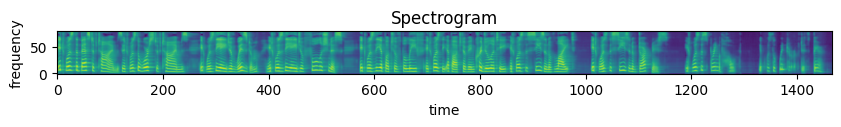

In [12]:
plt.figure(figsize=(10,12))
res_mel = mel[0].detach().cpu().numpy()
plt.imshow(res_mel, origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')
_=plt.title('Spectrogram')

Syntesize audio.

In [13]:
audio_numpy = audios[0].cpu().numpy()
Audio(audio_numpy, rate=22050)

Write audio to wav file.

In [16]:
from scipy.io.wavfile import write
# write("audio.wav", vocoder_train_setup['sampling_rate'], audio_numpy)
write("audio.wav", 16_000, audio_numpy)

### Details
For detailed information on model input and output, training recipies, inference and performance visit: [github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/HiFiGAN) and/or [NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/hifigan_pyt)

### References

 - [HiFi-GAN: Generative Adversarial Networks for Efficient and High Fidelity Speech Synthesis](https://arxiv.org/abs/2010.05646)
 - [Original implementation](https://github.com/jik876/hifi-gan)
 - [FastPitch on NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/fastpitch_pyt)
 - [HiFi-GAN on NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/hifigan_pyt)
 - [FastPitch and HiFi-GAN on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/HiFi-GAN)